# Unified Bank Statement Extraction

**Protocol**: Automatic strategy selection based on document characteristics

This notebook uses the `UnifiedBankExtractor` which automatically selects the optimal extraction strategy:

- **2-Turn Balance-Description**: When Balance column is detected (simpler, more reliable)
- **3-Turn Table Extraction**: When no Balance column exists (fallback)

---

## Workflow

```
Turn 0: Image → Header Detection (shared)
    ↓
Python: Pattern matching → Strategy selection
    ↓
Turn 1: Image → Extraction (strategy-specific)
    ↓
Python: Parsing → Filtering → Schema fields
```

## Configuration

All configs in `config/`:
- `model_config.yaml` - Model configurations (shared)
- `bank_prompts.yaml` - Bank statement extraction prompts
- `bank_column_patterns.yaml` - Column header pattern matching

In [1]:
# Cell 1: Deterministic setup and imports
# MUST be set before importing torch for deterministic CuBLAS
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import sys
from pathlib import Path

# Get project root (parent of bank_statement/)
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Change working directory to project root
os.chdir(project_root)
print(f"Working directory: {os.getcwd()}")

# Standard imports
import torch
from PIL import Image
from IPython.display import display

# Reproducibility
from common.reproducibility import set_seed, configure_deterministic_mode
set_seed(42)
configure_deterministic_mode(True)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

Working directory: /home/jovyan/nfs_share/tod/LMM_POC
✅ Random seed set to 42 for reproducibility
✅ PyTorch deterministic mode enabled
⚠️  Note: May reduce performance
PyTorch version: 2.5.1
CUDA available: True
CUDA version: 11.8


## Configuration

Select model and image path below.

In [2]:
# Cell 2: Configuration
import yaml

# ============================================================================
# SELECT MODEL - Choose from config/model_config.yaml
# ============================================================================
# Options (bfloat16 - no quantization):
#   "llama_3_2_vision", "internvl3_8b", "internvl3_2b", "internvl3_5_8b"
# Options (8-bit quantized):
#   "llama_3_2_vision_8bit", "internvl3_8b_8bit", "internvl3_2b_8bit", "internvl3_5_8b_8bit"
MODEL_KEY = "internvl3_5_8b"

# ============================================================================
# SELECT IMAGE
# ============================================================================
# IMAGE_PATH = "evaluation_data/bank/minimal/image_003.png"
# IMAGE_PATH = "evaluation_data/bank/minimal/image_008.png"
IMAGE_PATH = "evaluation_data/bank/minimal/image_009.png"

# ============================================================================
# GROUND TRUTH (optional, for evaluation)
# ============================================================================
GROUND_TRUTH_PATH = "evaluation_data/bank/ground_truth_bank.csv"

# ============================================================================
# Load model config
# ============================================================================
with open("config/model_config.yaml") as f:
    models_config = yaml.safe_load(f)

model_config = models_config["models"][MODEL_KEY]
loading_config = model_config.get("loading", {})
image_processing_config = model_config.get("image_processing", {})

print(f"Selected model: {model_config['name']}")
print(f"Model type: {model_config['type']}")
print(f"Model path: {model_config['default_path']}")
print(f"Quantization: {loading_config.get('quantization', 'none')}")
print(f"Torch dtype: {loading_config.get('torch_dtype', 'bfloat16')}")
if image_processing_config:
    print(f"Max tiles: {image_processing_config.get('max_tiles', 14)}")
    print(f"Input size: {image_processing_config.get('input_size', 448)}")

Selected model: InternVL3.5-8B (bfloat16)
Model type: internvl3
Model path: /home/jovyan/nfs_share/models/InternVL3_5-8B
Quantization: none
Torch dtype: bfloat16
Max tiles: 36
Input size: 448


## Load Model

Model loading is model-type specific. The cell below handles both Llama and InternVL3.

In [3]:
# Cell 3: Load model based on EXPLICIT config (no silent fallbacks)
import math

MODEL_PATH = model_config["default_path"]
MODEL_TYPE = model_config["type"]
QUANTIZATION = loading_config.get("quantization", "none")
TORCH_DTYPE_STR = loading_config.get("torch_dtype", "bfloat16")

# Map string dtype to torch dtype
DTYPE_MAP = {
    "bfloat16": torch.bfloat16,
    "float16": torch.float16,
    "float32": torch.float32,
}
TORCH_DTYPE = DTYPE_MAP.get(TORCH_DTYPE_STR, torch.bfloat16)

print(f"Loading model: {model_config['name']}")
print(f"  Path: {MODEL_PATH}")
print(f"  Quantization: {QUANTIZATION}")
print(f"  Dtype: {TORCH_DTYPE_STR}")

if MODEL_TYPE == "llama":
    # ========================================================================
    # LLAMA MODEL LOADING
    # ========================================================================
    from common.llama_model_loader_robust import load_llama_model_robust
    
    gen_config = model_config.get("generation", {})
    
    model, processor = load_llama_model_robust(
        model_path=MODEL_PATH,
        use_quantization=(QUANTIZATION == "8bit"),
        device_map=loading_config.get("device_map", "auto"),
        max_new_tokens=gen_config.get("max_new_tokens", 4096),
        torch_dtype=TORCH_DTYPE_STR,
        low_cpu_mem_usage=loading_config.get("low_cpu_mem_usage", True),
        verbose=True
    )
    
    if loading_config.get("tie_weights", True):
        try:
            model.tie_weights()
            print("Model weights tied")
        except Exception as e:
            print(f"tie_weights() warning: {e}")
    
    tokenizer = None
    model_dtype = TORCH_DTYPE

else:
    # ========================================================================
    # INTERNVL3 MODEL LOADING - EXPLICIT CONFIG
    # ========================================================================
    from transformers import AutoModel, AutoTokenizer, AutoConfig, BitsAndBytesConfig
    
    print(f"Loading InternVL3 model...")
    
    # Multi-GPU device mapping helper
    def split_model(model_path):
        """Official InternVL3 multi-GPU device mapping."""
        device_map = {}
        world_size = torch.cuda.device_count()
        config = AutoConfig.from_pretrained(model_path, trust_remote_code=True)
        num_layers = config.llm_config.num_hidden_layers
        
        num_layers_per_gpu = math.ceil(num_layers / (world_size - 0.5))
        num_layers_per_gpu = [num_layers_per_gpu] * world_size
        num_layers_per_gpu[0] = math.ceil(num_layers_per_gpu[0] * 0.5)
        
        layer_cnt = 0
        for i, num_layer in enumerate(num_layers_per_gpu):
            for _ in range(num_layer):
                device_map[f'language_model.model.layers.{layer_cnt}'] = i
                layer_cnt += 1
        
        device_map['vision_model'] = 0
        device_map['mlp1'] = 0
        device_map['language_model.model.tok_embeddings'] = 0
        device_map['language_model.model.embed_tokens'] = 0
        device_map['language_model.output'] = 0
        device_map['language_model.model.norm'] = 0
        device_map['language_model.model.rotary_emb'] = 0
        device_map['language_model.lm_head'] = 0
        device_map[f'language_model.model.layers.{num_layers - 1}'] = 0
        
        return device_map
    
    if QUANTIZATION == "8bit":
        # 8-bit quantized loading (explicit config)
        print("  Mode: 8-bit quantization")
        quantization_config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_enable_fp32_cpu_offload=False
        )
        model = AutoModel.from_pretrained(
            MODEL_PATH,
            torch_dtype=TORCH_DTYPE,
            low_cpu_mem_usage=loading_config.get("low_cpu_mem_usage", True),
            use_flash_attn=loading_config.get("use_flash_attn", False),
            trust_remote_code=loading_config.get("trust_remote_code", True),
            quantization_config=quantization_config,
            device_map={"": 0},
        ).eval()
    else:
        # Non-quantized loading (bfloat16/float16)
        print(f"  Mode: {TORCH_DTYPE_STR} (no quantization)")
        world_size = torch.cuda.device_count()
        
        if world_size > 1:
            print(f"  Multi-GPU: {world_size} GPUs detected")
            device_map = split_model(MODEL_PATH)
        else:
            print("  Single GPU")
            device_map = {"": 0}
        
        model = AutoModel.from_pretrained(
            MODEL_PATH,
            torch_dtype=TORCH_DTYPE,
            low_cpu_mem_usage=loading_config.get("low_cpu_mem_usage", True),
            use_flash_attn=loading_config.get("use_flash_attn", False),
            trust_remote_code=loading_config.get("trust_remote_code", True),
            device_map=device_map,
        ).eval()
    
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_PATH, 
        trust_remote_code=True, 
        use_fast=False
    )
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    
    processor = None
    model_dtype = TORCH_DTYPE

print(f"\nModel loaded successfully!")
print(f"  Final dtype: {model_dtype}")

Loading model: InternVL3.5-8B (bfloat16)
  Path: /home/jovyan/nfs_share/models/InternVL3_5-8B
  Quantization: none
  Dtype: bfloat16


`torch_dtype` is deprecated! Use `dtype` instead!


Loading InternVL3 model...
  Mode: bfloat16 (no quantization)
  Single GPU
FlashAttention2 is not installed.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


Model loaded successfully!
  Final dtype: torch.bfloat16


## Load Image

Loading image: evaluation_data/bank/minimal/image_009.png
Image size: (800, 1200)


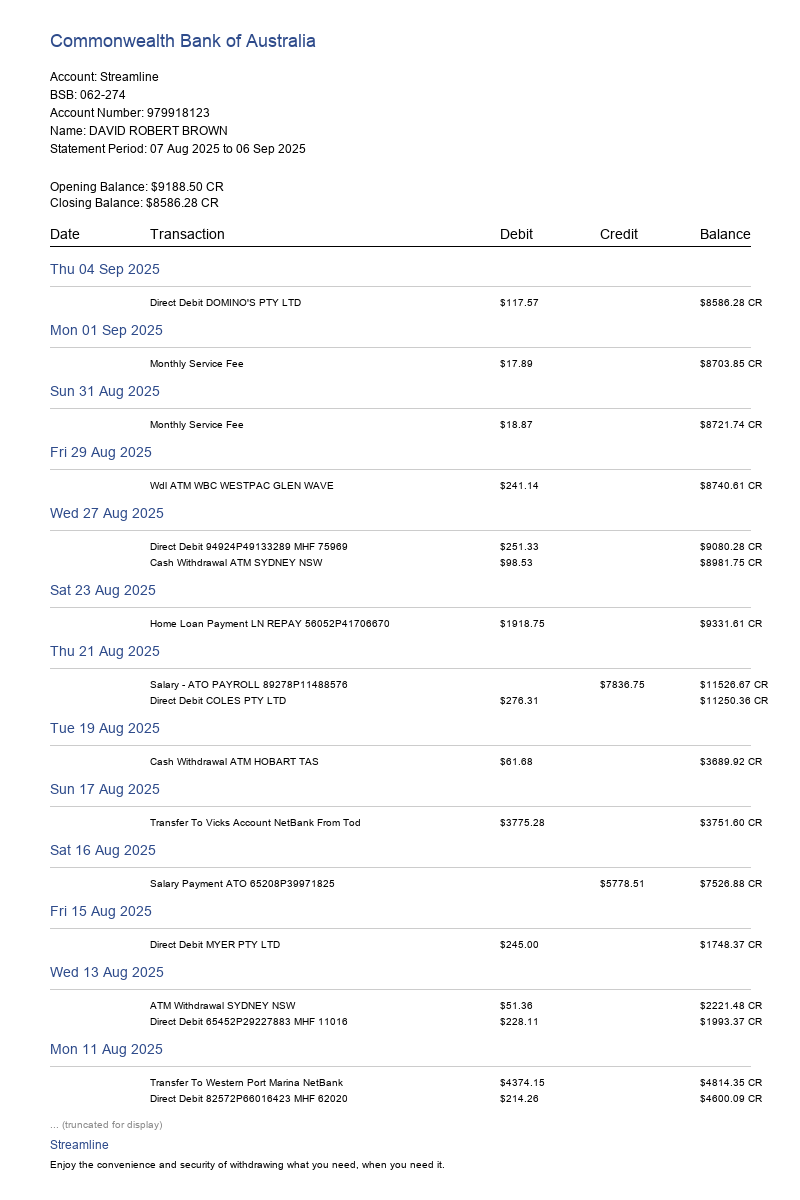

In [4]:
# Cell 4: Load image
print(f"Loading image: {IMAGE_PATH}")
image = Image.open(IMAGE_PATH).convert("RGB")
print(f"Image size: {image.size}")
display(image)

## Create Extractor and Extract

The `UnifiedBankExtractor` automatically:
1. Detects column headers (Turn 0)
2. Maps headers to semantic types
3. Selects optimal strategy based on Balance column presence
4. Executes extraction
5. Parses and filters results

In [5]:
# Cell 5: Create extractor and run extraction
from common.unified_bank_extractor import UnifiedBankExtractor

# Create extractor with image processing config from YAML
# Balance correction is disabled by default (set to True to enable)
extractor = UnifiedBankExtractor(
    model=model,
    tokenizer=tokenizer,
    processor=processor,
    model_type=MODEL_TYPE,
    model_dtype=model_dtype,
    image_processing_config=image_processing_config,
    use_balance_correction=False,  # Explicit: disabled by default
)

print("="*60)
print("UNIFIED BANK STATEMENT EXTRACTION")
print("="*60)
print(f"Max tiles: {extractor.max_tiles}")
print(f"Input size: {extractor.input_size}")
print(f"Balance correction: {'enabled' if extractor.use_balance_correction else 'disabled'}")

# Run extraction
result = extractor.extract(image)

print("\n" + "="*60)
print("EXTRACTION COMPLETE")
print("="*60)

UNIFIED BANK STATEMENT EXTRACTION
Max tiles: 36
Input size: 448
Balance correction: disabled
Turn 0: Detecting headers...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


  Detected 5 headers: ['Date', 'Transaction', 'Debit', 'Credit', 'Balance']
  Balance column: Balance
Strategy: BALANCE_DESCRIPTION (Balance column detected)
Turn 1: Extracting transactions...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


  Parsed 17 transactions
  Filtered to 15 debit transactions

EXTRACTION COMPLETE


## View Results

In [6]:
# Cell 6: Display extraction results
print("="*60)
print("EXTRACTION METADATA")
print("="*60)
print(f"Strategy used: {result.strategy_used}")
print(f"Turns executed: {result.turns_executed}")
print(f"Headers detected: {result.headers_detected}")
if result.column_mapping:
    print(f"\nColumn mapping:")
    print(f"  Date: {result.column_mapping.date}")
    print(f"  Description: {result.column_mapping.description}")
    print(f"  Debit: {result.column_mapping.debit}")
    print(f"  Credit: {result.column_mapping.credit}")
    print(f"  Balance: {result.column_mapping.balance}")

# Display balance correction stats
if result.correction_stats:
    print(f"\nBalance correction:")
    print(f"  Total transactions: {result.correction_stats.total_transactions}")
    print(f"  Debits identified: {result.correction_stats.debits_found}")
    print(f"  Credits identified: {result.correction_stats.credits_found}")
    print(f"  Corrections made: {result.correction_stats.corrections_made}")
    if result.correction_stats.corrections_made > 0:
        print(f"    - Type corrections (debit<->credit): {result.correction_stats.type_corrections}")
        print(f"    - Amount corrections: {result.correction_stats.amount_corrections}")
    if result.correction_stats.unparseable_balances > 0:
        print(f"  Unparseable balances: {result.correction_stats.unparseable_balances}")

print("\n" + "="*60)
print("EXTRACTED SCHEMA FIELDS")
print("="*60)
schema = result.to_schema_dict()
for field, value in schema.items():
    display_value = str(value)[:100] + "..." if len(str(value)) > 100 else str(value)
    print(f"\n{field}:")
    print(f"  {display_value}")

print("\n" + "="*60)
print("TRANSACTION SUMMARY")
print("="*60)
print(f"Total debit transactions: {len(result.transaction_dates)}")
print(f"Date range: {result.statement_date_range}")

EXTRACTION METADATA
Strategy used: balance_description_2turn
Turns executed: 2
Headers detected: ['Date', 'Transaction', 'Debit', 'Credit', 'Balance']

Column mapping:
  Date: Date
  Description: Transaction
  Debit: Debit
  Credit: Credit
  Balance: Balance

EXTRACTED SCHEMA FIELDS

DOCUMENT_TYPE:
  BANK_STATEMENT

STATEMENT_DATE_RANGE:
  11 Aug 2025 - 04 Sep 2025

TRANSACTION_DATES:
  Thu 04 Sep 2025 | Mon 01 Sep 2025 | Sun 31 Aug 2025 | Fri 29 Aug 2025 | Wed 27 Aug 2025 | Sat 23 Aug...

LINE_ITEM_DESCRIPTIONS:
  Direct Debit DOMINO'S PTY LTD | Monthly Service Fee | Monthly Service Fee | Wdl ATM WBC WESTPAC GLEN...

TRANSACTION_AMOUNTS_PAID:
  $117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | $276.31 | $61.68 | $3775.28 | $2...

TRANSACTION SUMMARY
Total debit transactions: 15
Date range: 11 Aug 2025 - 04 Sep 2025


In [7]:
# Cell 7: Display individual transactions
print("="*60)
print("DEBIT TRANSACTIONS")
print("="*60)

for i, (date, desc, amount) in enumerate(zip(
    result.transaction_dates,
    result.line_item_descriptions,
    result.transaction_amounts_paid
), 1):
    print(f"{i}. [{date}] {desc[:50]}{'...' if len(desc) > 50 else ''} - {amount}")

DEBIT TRANSACTIONS
1. [Thu 04 Sep 2025] Direct Debit DOMINO'S PTY LTD - $117.57
2. [Mon 01 Sep 2025] Monthly Service Fee - $17.89
3. [Sun 31 Aug 2025] Monthly Service Fee - $18.87
4. [Fri 29 Aug 2025] Wdl ATM WBC WESTPAC GLEN WAVE - $241.14
5. [Wed 27 Aug 2025] Direct Debit 94924P49133289 MHF 75696 - $251.33
6. [Sat 23 Aug 2025] Cash Withdrawal ATM SYDNEY NSW - $98.53
7. [Sat 23 Aug 2025] Home Loan Payment LN REPAY 56052P41706870 - $1918.75
8. [Thu 21 Aug 2025] Direct Debit COLES PTY LTD - $276.31
9. [Tue 19 Aug 2025] Cash Withdrawal ATM HOBART TAS - $61.68
10. [Sun 17 Aug 2025] Transfer To Vicks Account NetBank From Tod - $3775.28
11. [Fri 15 Aug 2025] Direct Debit MYER PTY LTD - $245.00
12. [Wed 13 Aug 2025] ATM Withdrawal SYDNEY NSW - $51.36
13. [Wed 13 Aug 2025] Direct Debit 65452P29227883 MHF 11016 - $228.11
14. [Mon 11 Aug 2025] Transfer To Western Port Marina NetBank - $4374.15
15. [Mon 11 Aug 2025] Direct Debit 82572P68016423 MHF 62020 - $214.28


## Evaluation (Optional)

Compare extracted results against ground truth.

In [8]:
# Cell 8: Load ground truth and evaluate
import pandas as pd
from pathlib import Path

# Import evaluation metrics
from common.evaluation_metrics import (
    calculate_field_accuracy_f1,
    load_ground_truth,
)

# Bank statement fields to evaluate
BANK_STATEMENT_FIELDS = [
    "DOCUMENT_TYPE",
    "STATEMENT_DATE_RANGE",
    "TRANSACTION_DATES",
    "LINE_ITEM_DESCRIPTIONS",
    "TRANSACTION_AMOUNTS_PAID",
]

# Load ground truth
print("Loading ground truth...")
try:
    ground_truth_map = load_ground_truth(GROUND_TRUTH_PATH, verbose=True)
    
    # Get image filename
    image_filename = Path(IMAGE_PATH).name
    print(f"Looking up: {image_filename}")
    
    if image_filename in ground_truth_map:
        gt_data = ground_truth_map[image_filename]
        print("Ground truth found!")
        
        # Calculate F1 scores
        print("\n" + "="*60)
        print("EVALUATION RESULTS")
        print("="*60)
        
        total_f1 = 0.0
        for field in BANK_STATEMENT_FIELDS:
            extracted = schema.get(field, "NOT_FOUND")
            ground_truth = gt_data.get(field, "NOT_FOUND")
            
            if pd.isna(ground_truth):
                ground_truth = "NOT_FOUND"
            
            result_eval = calculate_field_accuracy_f1(extracted, ground_truth, field)
            f1 = result_eval.get("f1_score", 0.0)
            total_f1 += f1
            
            status = "OK" if f1 == 1.0 else ("PARTIAL" if f1 >= 0.5 else "FAIL")
            print(f"{status:7} {field:30} F1: {f1:.1%}")
        
        overall_f1 = total_f1 / len(BANK_STATEMENT_FIELDS)
        print("\n" + "-"*60)
        print(f"OVERALL F1 SCORE: {overall_f1:.1%}")
        print("="*60)
    else:
        print(f"No ground truth found for: {image_filename}")
        
except FileNotFoundError:
    print(f"Ground truth file not found: {GROUND_TRUTH_PATH}")
    print("Skipping evaluation.")

DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']
Loading ground truth...
📊 Ground truth CSV loaded with 13 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_AD

## View Raw Responses (Debug)

In [9]:
# Cell 9: View raw LLM responses (for debugging)
print("="*60)
print("RAW TURN 0 RESPONSE (Header Detection)")
print("="*60)
print(result.raw_responses.get("turn0", "N/A"))

print("\n" + "="*60)
print("RAW TURN 1 RESPONSE (Extraction)")
print("="*60)
print(result.raw_responses.get("turn1", "N/A")[:10000])
if len(result.raw_responses.get("turn1", "")) > 10000:
    print("... [truncated]")

RAW TURN 0 RESPONSE (Header Detection)
The exact column header names used in the transaction table are:

1. Date
2. Transaction
3. Debit
4. Credit
5. Balance

RAW TURN 1 RESPONSE (Extraction)
1. **Thu 04 Sep 2025**
   - Transaction: Direct Debit DOMINO'S PTY LTD
   - Debit: $117.57
   - Credit: NOT_FOUND
   - Balance: $8586.28 CR

2. **Mon 01 Sep 2025**
   - Transaction: Monthly Service Fee
   - Debit: $17.89
   - Credit: NOT_FOUND
   - Balance: $8703.85 CR

3. **Sun 31 Aug 2025**
   - Transaction: Monthly Service Fee
   - Debit: $18.87
   - Credit: NOT_FOUND
   - Balance: $8721.74 CR

4. **Fri 29 Aug 2025**
   - Transaction: Wdl ATM WBC WESTPAC GLEN WAVE
   - Debit: $241.14
   - Credit: NOT_FOUND
   - Balance: $8740.61 CR

5. **Wed 27 Aug 2025**
   - Transaction: Direct Debit 94924P49133289 MHF 75696
   - Debit: $251.33
   - Credit: NOT_FOUND
   - Balance: $9080.28 CR

6. **Sat 23 Aug 2025**
   - Transaction: Cash Withdrawal ATM SYDNEY NSW
   - Debit: $98.53
   - Credit: NOT_FOUND
   

## Summary

In [10]:
# Cell 10: Final summary
print("\n" + "="*60)
print("EXTRACTION SUMMARY")
print("="*60)
print(f"\nModel: {model_config['name']}")
print(f"Image: {IMAGE_PATH}")
print(f"Strategy: {result.strategy_used}")
print(f"Headers: {len(result.headers_detected)} detected")
print(f"Balance column: {result.column_mapping.balance if result.column_mapping else 'N/A'}")
print(f"Transactions extracted: {len(result.transaction_dates)} debits")
print(f"Date range: {result.statement_date_range}")
print(f"\nPipeline complete!")


EXTRACTION SUMMARY

Model: InternVL3.5-8B (bfloat16)
Image: evaluation_data/bank/minimal/image_009.png
Strategy: balance_description_2turn
Headers: 5 detected
Balance column: Balance
Transactions extracted: 15 debits
Date range: 11 Aug 2025 - 04 Sep 2025

Pipeline complete!
